# 04 homework

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

Data preparation
* Check if the missing values are presented in the features.
* If there are missing values:
  * For caterogiral features, replace them with 'NA'
  * For numerical features, replace with with 0.0

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [2]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"

In [3]:
df = pd.read_csv(data)
df.head(4)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [5]:
categorical_columns = ['lead_source', 'industry', 'employment_status', 'location']
numerical_columns = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [6]:
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [7]:
df[categorical_columns] = df[categorical_columns].fillna('NA')
df[numerical_columns] = df[numerical_columns].fillna(0)

In [8]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=1) 

print(len(df_train), len(df_val), len(df_test))

876 293 293


In [9]:
y_train = df_train['converted'].reset_index(drop=True)
y_val = df_val['converted'].reset_index(drop=True)
y_test = df_test['converted'].reset_index(drop=True)

del df_train['converted']
del df_val['converted']
del df_test['converted']

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

In [10]:
auc_scores = {}

for c in numerical_columns:
    auc = roc_auc_score(y_train.to_numpy(), df_train[c].to_numpy())
    #auc = max(auc, 1 - auc)  # handle inverse correlation
    auc_scores[c] = auc

auc_scores

{'number_of_courses_viewed': 0.7635680590007088,
 'annual_income': 0.5519578313253012,
 'interaction_count': 0.738270176293409,
 'lead_score': 0.6144993577250176}

In [11]:
print(y_train[10:20].to_numpy())
print(df_train['annual_income'][10:20].to_numpy())

[1 0 0 1 0 0 1 0 1 1]
[65782. 68293. 56746. 52409. 58164. 61242. 62672. 63391. 62630. 82306.]


In [12]:
roc_auc_score(y_train[10:20].to_numpy(), df_train['annual_income'][10:20].to_numpy())

0.6

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [13]:
def train(xtrain, ytrain, C=1.0, max_iter=1000):
    # do standard scaler for numerical columns
    for col in xtrain.select_dtypes(include=['float64', 'int64']).columns:
        xtrain[col] = (xtrain[col] - xtrain[col].mean()) / xtrain[col].std()

    dicts = xtrain.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    #print(X_train.shape)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=max_iter)
    model.fit(X_train, ytrain)

    return dv, model

In [14]:
def predict(xval, dv, model):
    # do standard scaler for numerical columns
    for col in xval.select_dtypes(include=['float64', 'int64']).columns:
        xval[col] = (xval[col] - xval[col].mean()) / xval[col].std()

    dicts = xval.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [15]:
dv, model = train(df_train, y_train.to_numpy(), C=1.0, max_iter=1000)

In [16]:
y_val_pred_proba = predict(df_val, dv, model)



In [17]:
roc_auc_score(y_val.to_numpy(), y_val_pred_proba)

0.9202377528520754

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745


In [18]:
# generate array from 0 to 1 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

array_precision = []
array_recall = []

In [19]:
for t in thresholds:
    y_val_pred = (y_val_pred_proba >= t).astype(int)

    # calculate precision and recall
    cf = confusion_matrix(y_val.to_numpy(), y_val_pred)

    precision = cf[1, 1] / (cf[1, 1] + cf[0, 1])
    recall = cf[1, 1] / (cf[1, 1] + cf[1, 0])
    #print(precision, recall)

    array_precision.append(precision)
    array_recall.append(recall)

    #break


C:\Users\biggi\AppData\Local\Temp\ipykernel_12248\662838770.py:7: RuntimeWarning: invalid value encountered in scalar divide
  precision = cf[1, 1] / (cf[1, 1] + cf[0, 1])


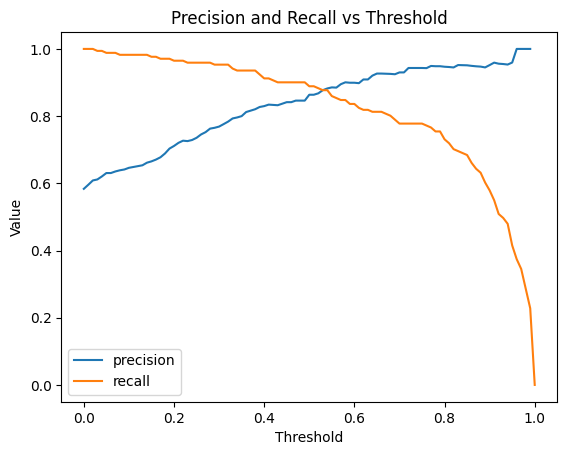

In [20]:
plt.plot(thresholds, array_precision, label='precision')
plt.plot(thresholds, array_recall, label='recall')  
plt.title('Precision and Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.legend()
plt.show()

In [21]:
# threshold with precision cross recall
for i in range(len(thresholds)):
    if array_precision[i] >= array_recall[i]:
        print(f'Threshold: {thresholds[i]:.2f}, Precision: {array_precision[i]:.3f}, Recall: {array_recall[i]:.3f}')
        break

Threshold: 0.53, Precision: 0.877, Recall: 0.877


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [22]:
# generate array from 0 to 1 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

array_f1 = []

for t in thresholds:
    y_val_pred = (y_val_pred_proba >= t).astype(int)

    # calculate precision and recall
    cf = confusion_matrix(y_val.to_numpy(), y_val_pred)

    precision = cf[1, 1] / (cf[1, 1] + cf[0, 1])
    recall = cf[1, 1] / (cf[1, 1] + cf[1, 0])

    f1 = 2 * (precision * recall) / (precision + recall)
    array_f1.append(f1)

C:\Users\biggi\AppData\Local\Temp\ipykernel_12248\4064815228.py:12: RuntimeWarning: invalid value encountered in scalar divide
  precision = cf[1, 1] / (cf[1, 1] + cf[0, 1])


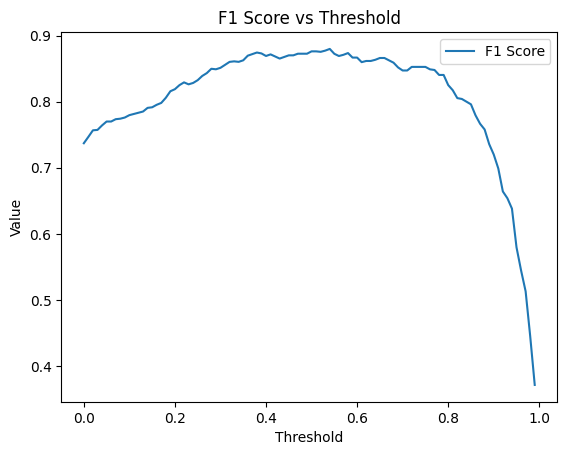

In [23]:
plt.plot(thresholds, array_f1, label='F1 Score')
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.legend()
plt.show()

In [24]:
# get f1 max and the corresponding threshold
max_f1 = max(array_f1)
max_f1_threshold = thresholds[array_f1.index(max_f1)]

print('Max F1 Score: {:.3f} at Threshold: {:.2f}'.format(max_f1, max_f1_threshold))

Max F1 Score: 0.880 at Threshold: 0.54


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [25]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

array_auc = []

for train_idx, val_idx in kfold.split(df):
    x_train = df.iloc[train_idx].reset_index(drop=True)
    x_val = df.iloc[val_idx].reset_index(drop=True)

    y_train = df['converted'].iloc[train_idx].reset_index(drop=True)
    y_val = df['converted'].iloc[val_idx].reset_index(drop=True)

    del x_train['converted']
    del x_val['converted']

    dv, model = train(x_train, y_train.to_numpy(), C=1.0, max_iter=1000)
    y_val_pred_proba = predict(x_val, dv, model)

    auc = roc_auc_score(y_val.to_numpy(), y_val_pred_proba)
    print(f'ROC AUC: {auc:.3f}')

    array_auc.append(auc)

print(f'Mean ROC AUC: {np.mean(array_auc):.3f}')
print(f'STD ROC AUC: {np.std(array_auc):.3f}')

ROC AUC: 0.924
ROC AUC: 0.912
ROC AUC: 0.936
ROC AUC: 0.928
ROC AUC: 0.916
Mean ROC AUC: 0.923
STD ROC AUC: 0.008


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [27]:
array_c = [0.000001, 0.001, 1]

kfold = KFold(n_splits=5, shuffle=True, random_state=1)


for c in array_c:
    array_auc = []

    print('c =', c)
    for train_idx, val_idx in kfold.split(df):
        x_train = df.iloc[train_idx].reset_index(drop=True)
        x_val = df.iloc[val_idx].reset_index(drop=True)

        y_train = df['converted'].iloc[train_idx].reset_index(drop=True)
        y_val = df['converted'].iloc[val_idx].reset_index(drop=True)

        del x_train['converted']
        del x_val['converted']

        dv, model = train(x_train, y_train.to_numpy(), C=c, max_iter=1000)
        y_val_pred_proba = predict(x_val, dv, model)

        auc = roc_auc_score(y_val.to_numpy(), y_val_pred_proba)
        print(f'ROC AUC: {auc:.3f}')

        array_auc.append(auc)

    print(f'Mean ROC AUC: {np.mean(array_auc):.3f}')
    print(f'STD ROC AUC: {np.std(array_auc):.3f}')
    print('-----')

c = 1e-06
ROC AUC: 0.885
ROC AUC: 0.891
ROC AUC: 0.907
ROC AUC: 0.917
ROC AUC: 0.905
Mean ROC AUC: 0.901
STD ROC AUC: 0.011
-----
c = 0.001
ROC AUC: 0.889
ROC AUC: 0.893
ROC AUC: 0.910
ROC AUC: 0.918
ROC AUC: 0.908
Mean ROC AUC: 0.904
STD ROC AUC: 0.011
-----
c = 1
ROC AUC: 0.924
ROC AUC: 0.912
ROC AUC: 0.936
ROC AUC: 0.928
ROC AUC: 0.916
Mean ROC AUC: 0.923
STD ROC AUC: 0.008
-----
